In [13]:
import os

In [62]:
model_name = 'amodel45'
csv_file ='HR_10000_kmeans_6c.csv'
n_classes = 6

In [63]:
# os.listdir('/data1/Itzel/AGAN_results/' + model_name + '/checkpoints/')

In [64]:
checkpoint_nr = 450

In [65]:
import argparse
import time
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import warnings
import math
warnings.filterwarnings('ignore')
import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torch.nn.functional as F
torch.manual_seed(0)
import csv

import scipy
from scipy.stats import truncnorm
from torchvision.models import inception_v3
from torch.distributions import MultivariateNormal
import seaborn as sns

In [66]:
z_dim = 64
batch_size = 256
lr = 0.0002
b1 = 0.5
b2 = 0.999
img_size = 96

# FIXED PARAMETERS
device = 'cuda:0'
data_shape = (3, img_size, img_size)

In [67]:
# DATASET
class HeerlenDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = cv2.imread(img_path)
        image =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
        
        return (image, y_label)

    

# GET THE DATASET
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    # mean = 0.5, std = 0.5, from (0,1) to (-1,1)
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) 
])

#dataset_path = 'D:/Heerlen_HR_2018/Heerlen_HR_2018/Heerlen_HR_2018/full/'
dataset_path = '/data1/Heerlen_HR_2018/full/'
dataset = HeerlenDataset(csv_file= '/data1/Itzel/csv_files/' + csv_file,
                                      root_dir=dataset_path,
                                      transform=transform)

In [68]:
# SOME HELPER FUNCTIONS
def get_one_hot_labels(labels, n_classes):
    return F.one_hot(labels,n_classes)

def combine_vectors(x, y):
    combined = torch.cat([x.float(),y.float()], dim=1)
    return combined

In [69]:
class AttentionBlock(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.channels = channels

        self.theta = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=False))
        self.phi = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 8, kernel_size=1, padding=0, bias=False))
        self.g = nn.utils.spectral_norm(nn.Conv2d(channels, channels // 2, kernel_size=1, padding=0, bias=False))
        self.o = nn.utils.spectral_norm(nn.Conv2d(channels // 2, channels, kernel_size=1, padding=0, bias=False))

        self.gamma = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def forward(self, x):
        spatial_size = x.shape[2] * x.shape[3]

        # Apply convolutions to get query (theta), key (phi), and value (g) transforms
        theta = self.theta(x)
        phi = F.max_pool2d(self.phi(x), kernel_size=2)
        g = F.max_pool2d(self.g(x), kernel_size=2)

        # Reshape spatial size for self-attention
        theta = theta.view(-1, self.channels // 8, spatial_size)
        phi = phi.view(-1, self.channels // 8, spatial_size // 4)
        g = g.view(-1, self.channels // 2, spatial_size // 4)

        # Compute dot product attention with query (theta) and key (phi) matrices
        beta = F.softmax(torch.bmm(theta.transpose(1, 2), phi), dim=-1)

        # Compute scaled dot product attention with value (g) and attention (beta) matrices
        o = self.o(torch.bmm(g, beta.transpose(1, 2)).view(-1, self.channels // 2, x.shape[2], x.shape[3]))

        # Apply gain and residual
        return self.gamma * o + x

In [70]:
class GenBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        super().__init__()
        
        self.conv = nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride)
        #self.conv = nn.utils.spectral_norm(nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride))
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [71]:
# GENERATOR amodel3
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.input_dim =  z_dim + n_classes

        self.g_blocks = nn.ModuleList([
            
                GenBlock(self.input_dim, 512, kernel_size=4, stride=2),
                AttentionBlock(512),
                GenBlock(512, 256, kernel_size=4, stride=2),
                AttentionBlock(256),
                GenBlock(256, 128, kernel_size=4, stride=2),
                GenBlock(128, 64, kernel_size=5, stride=2),
            ])
     
        self.proj_o = nn.Sequential(
                nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2),
                nn.Tanh(),
            )
        
    def forward(self, noise):
        gen_input = noise.view(len(noise), self.input_dim, 1, 1)
             
        h = self.g_blocks[0](gen_input)

        for idx, g_block in enumerate(self.g_blocks):
            if idx != 0:
                h = g_block(h)
        h = self.proj_o(h)
        return h
    
    
def get_noise(n_samples, z_dim, device='cpu'):

    return torch.randn(n_samples, z_dim, device=device)


In [72]:
# # GENERATOR
# class Generator(nn.Module):

#     def __init__(self, im_chan=3, hidden_dim=64):
#         super(Generator, self).__init__()
#         self.input_dim =  z_dim + n_classes
#         # Build the neural network
#         self.gen = nn.Sequential(
#             self.block(self.input_dim, 256, kernel_size=4, stride=2),
#             self.block(256, 128, kernel_size=5, stride=2),
#             self.block(128, 64, kernel_size=3, stride=2),
#             self.block(64, 32, kernel_size=3, stride=2),
#             self.block(32, 3, kernel_size=4, stride=2, final_layer=True),
#         )

#     def block(self, input_channels, output_channels,kernel_size=3, stride=2, final_layer=False):

#         if not final_layer:
#             return nn.Sequential(
#                 nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
#                 nn.BatchNorm2d(output_channels),
#                 nn.ReLU(inplace=True),
#             )
#         else:
#             return nn.Sequential(
#                 nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
#                 nn.Tanh(),
#             )

#     def forward(self, noise):

#         gen_input = noise.view(len(noise),  z_dim + n_classes, 1, 1) # creates a (n_samples, 64 + 2, 1, 1) tensor
#         return self.gen(gen_input)

# def get_noise(n_samples, input_dim, device='cpu'):

#     return torch.randn(n_samples, input_dim, device=device)

In [73]:
# class Generator(nn.Module):

#     def __init__(self, im_chan=3, hidden_dim=64):
#         super(Generator, self).__init__()
#         self.input_dim =  z_dim + n_classes
#         # Build the neural network
#         self.gen = nn.Sequential(
#             self.block(self.input_dim, 256, kernel_size=4, stride=2),
#             self.block(256, 128, kernel_size=5, stride=2),
#             self.block(128, 64, kernel_size=3, stride=2),
#             self.block(64, 32, kernel_size=3, stride=2),
#             self.block(32, 3, kernel_size=4, stride=2, final_layer=True),
#         )

#     def block(self, input_channels, output_channels,kernel_size=3, stride=2, final_layer=False):

#         if not final_layer:
#             return nn.Sequential(
#                 nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
#                 #nn.utils.spectral_norm(nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride)),
#                 nn.BatchNorm2d(output_channels),
#                 nn.ReLU(inplace=True),
#             )
#         else:
#             return nn.Sequential(
#                 nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
#                 #nn.utils.spectral_norm(nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride)),
#                 nn.Tanh(),
#             )

#     def forward(self, noise):

#         gen_input = noise.view(len(noise), self.input_dim, 1, 1)
#         return self.gen(gen_input)

# def get_noise(n_samples, z_dim, device='cpu'):

#     return torch.randn(n_samples, z_dim, device=device)

In [74]:
gen = Generator()
checkpoint_path = '/data1/Itzel/AGAN_results/' + model_name + '/checkpoints/chkpt_epoch{}.pt'.format(checkpoint_nr)
checkpoint = torch.load(checkpoint_path)

In [75]:
checkpoint.keys()

dict_keys(['G_state_dict', 'G_loss', 'D_loss'])

In [76]:
gen.load_state_dict(checkpoint['G_state_dict'])
gen.to(device)
gen.eval()
print('done')

done


### Visualize losses

In [77]:
G_loss = checkpoint['G_loss']
D_loss = checkpoint['D_loss']

In [78]:
# grad_norm = checkpoint['grad_norm']
# iterations_per_epoch = int(len(grad_norm) / len(D_loss))
# epoch_grad_norm = grad_norm[::iterations_per_epoch]
# len(epoch_grad_norm) == len(D_loss)

In [79]:
# # penalties = checkpoint['penalties']
# # epoch_penalties = penalties[::iterations_per_epoch]
# # len(epoch_penalties) == len(D_loss)

In [80]:
def plot_losses(G_loss, D_loss, upper_bound=None):
    fig = plt.figure()
    plt.plot(G_loss, label='Generator loss per epoch')
    plt.plot(D_loss, label='Critic loss per epoch')
    # plt.plot(epoch_penalties,'g:', label='Gradient penalty imposed on Critic loss'
    
    plt.title('Losses per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    #plt.ylim(-100,1100)
    #plt.xlim(600,800)
    plt.legend()
    plt.rcParams['figure.figsize'] = (10,5)
    plt.show()

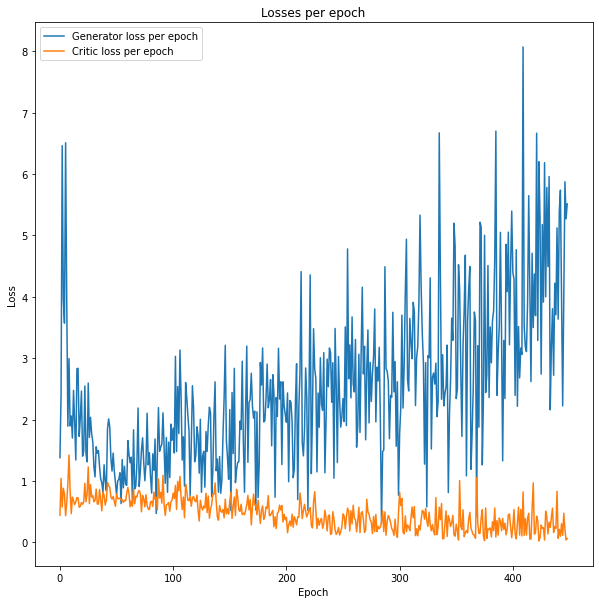

In [81]:
plot_losses(G_loss, D_loss,300)

In [82]:
def plot_final_grad_norms(avg_batch_grad_norms, upper_bound):
    up_bound = []
    for i in range(len(avg_batch_grad_norms)):
        up_bound.append(1)
    fig = plt.figure()
    plt.plot(avg_batch_grad_norms, label='Average gradient norm of batch')
    plt.plot(up_bound, 'r--' ,label='Upper bound')
    plt.title('Average gradient norm of a batch')
    plt.xlabel('Iterations')
    plt.ylabel('Average gradient norm')
    plt.ylim([-0.5,upper_bound])
    plt.legend()
    plt.rcParams['figure.figsize'] = (10,5)
    plt.show()

In [83]:
plot_final_grad_norms(grad_norm, 3)

NameError: name 'grad_norm' is not defined

### Frechet inception distance

In [84]:
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load('/data1/Itzel/pretrained_weights/inception_v3_google-1a9a5a14.pth'))

<All keys matched successfully>

In [85]:
inception_model.to(device)
inception_model.eval()
inception_model.fc = torch.nn.Identity()

In [86]:
# compute square root of matrix
def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

# mu (n_feat), sigma (n_feat, n_feat)
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    return (torch.norm(mu_x - mu_y))**2 + torch.trace(sigma_x + sigma_y - 2 * matrix_sqrt(sigma_x @ sigma_y))

# compute covariance
# def get_covariance(features):
#     return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

In [87]:
fake_features_list = []
real_features_list = []

n_samples = 512
batch_size = 4

# dataloader with new batch size
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

In [88]:
cur_samples = 0
with torch.no_grad():
    # go by batch instead of all samples
    try:
        for real_samples, labels in tqdm(dataloader, total = n_samples // batch_size):
            
            # put the reals in the inception model, output = tensor[batch, 2048]
            upsampled_reals = torch.nn.functional.interpolate(real_samples, size=(299, 299), mode='bilinear', align_corners=False)
            real_features = inception_model(real_samples.to(device)).detach().to('cpu')

            # append the feature vectors to the list, one batch = one list item
            real_features_list.append(real_features)

            # get the noise 
            fake_noise = get_noise(len(real_samples), z_dim).to(device)

            # get the one-hot labels of the current real batch
            one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)

            # concatenate the noise and one-hot labels
            noise_and_labels = torch.cat([fake_noise.float(),one_hot_labels.float()], dim=1)

            # generate the fakes with generator
            fake_samples = gen(noise_and_labels)

            # upsample the fakes to 299
            upsampled_fakes = torch.nn.functional.interpolate(fake_samples, size=(299, 299), mode='bilinear', align_corners=False)

            # get the fake features with inception
            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')

            # append the batch to the list
            fake_features_list.append(fake_features)
            
            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break
    except:
        print("Error")

 99%|█████████▉| 127/128 [00:07<00:00, 16.24it/s]


In [89]:
# get rid of separate batches
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

# get the mean and covariances of the real and fake feature embeddings
mu_fake = torch.mean(fake_features_all, dim=0)
mu_real = torch.mean(real_features_all, dim=0)
sigma_fake = torch.Tensor(np.cov(fake_features_all.detach().numpy(), rowvar=False))
sigma_real = torch.Tensor(np.cov(real_features_all.detach().numpy(), rowvar=False))

In [90]:
checkpoint_nr

450

In [91]:
since = time.time()
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())
time_elapsed = time.time() - since
print('FID computation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

240.96978759765625
FID computation complete in 2m 11s


### Visualize images

In [92]:
def show_all_images(nr_images, cluster_list, trunc=None, do_trunc=False):
    
    nr_clusters = len(cluster_list)
    imgs_per_class = round(nr_images/nr_clusters)
    
    nr_images = imgs_per_class * nr_clusters # assert the round doesnt change the nr

    generated_imgs = torch.empty(nr_clusters,imgs_per_class, 3, img_size, img_size)
    for index, cluster_nr in enumerate(cluster_list):
        label_shape = torch.empty(imgs_per_class)
        labels = label_shape.fill_(cluster_nr).to(torch.int64)
        one_hot_labels = F.one_hot(labels.to(device),n_classes)
        if do_trunc:      
            noise = torch.Tensor(truncnorm.rvs(-trunc, trunc, size=(imgs_per_class,z_dim)))
            noise = noise.to(device)
        else:
            noise = get_noise(imgs_per_class, z_dim, device=device)
        noise_and_labels = torch.cat([noise.float(),one_hot_labels.float()],dim=1)
        gen_imgs = gen(noise_and_labels)
        generated_imgs[index] = gen_imgs
    generated_imgs = generated_imgs.view(-1,3,img_size,img_size)
    
    nrow = len(cluster_list)
    nrow = 6
    grid_img = make_grid(tensor=generated_imgs.data,
                         nrow=nrow,
                         normalize=True)
    plt.rcParams['figure.figsize'] = (10,10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1,2,0))

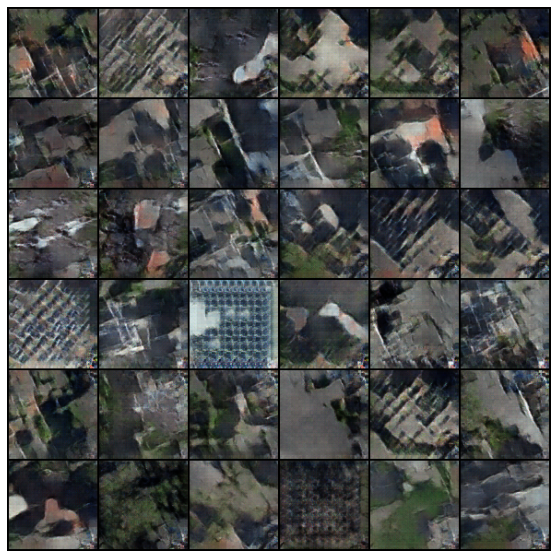

In [93]:
show_all_images(36, [0,1,2,3,4,5],1,False)

### Generate images

In [94]:
gen_imgs_path = '/data1/Itzel/AGAN_results/' + model_name + '/final_imgs5000'
gen_csv_path ='/data1/Itzel/AGAN_results/' + model_name + '/'
if not os.path.exists(gen_imgs_path):
    os.makedirs(gen_imgs_path)

In [97]:
def get_generated_imgs(nr_images, cluster_list, trunc=None, do_trunc=False):

    nr_clusters = len(cluster_list)
    
    imgs_per_class = round(nr_images/nr_clusters)
    nr_images = imgs_per_class * nr_clusters # assert the round doesnt change the nr

    generated_imgs = torch.empty(nr_clusters,imgs_per_class, 3, img_size, img_size)
    for index, cluster_nr in enumerate(cluster_list):
        label_shape = torch.empty(imgs_per_class)
        labels = label_shape.fill_(cluster_nr).to(torch.int64)
        one_hot_labels = F.one_hot(labels.to(device),n_classes)
        if do_trunc:      
            noise = torch.Tensor(truncnorm.rvs(-trunc, trunc, size=(imgs_per_class,z_dim)))
            noise = noise.to(device)
        else:
            noise = get_noise(imgs_per_class, z_dim, device=device)
        noise_and_labels = torch.cat([noise.float(),one_hot_labels.float()],dim=1)
        gen_imgs = gen(noise_and_labels)
        generated_imgs[index] = gen_imgs
    generated_imgs = generated_imgs.view(-1,3,img_size,img_size)
    
    id_label_list = []
    for i in range(nr_images):
        save_image(tensor=generated_imgs[i].data,
               fp=gen_imgs_path + '/images_%d.png' % (i),
              normalize=True) 
        id_label_list.append(('images_%d.png' % (i), 1))
        
    id_label_file = open(gen_csv_path + 'labels_%d_samples.csv' % (nr_images), 'w')
    writer = csv.writer(id_label_file)
    writer.writerow(['unique_id', 'label'])
    for the_id, label in id_label_list:
        writer.writerow([the_id, label])

    id_label_file.close()

In [98]:
get_generated_imgs(5000, [0,1,2,3,4])

In [99]:
len(os.listdir(gen_imgs_path))

5000

### Check generated images

In [100]:
def show_images(nr_images):
    
    img_names = os.listdir(gen_imgs_path)
    
    gen_imgs = torch.empty(nr_images, 3, 96, 96)
    for i in range(nr_images):
        img_idx = random.randrange(0,len(os.listdir(gen_imgs_path)))
        image = cv2.imread(gen_imgs_path + '/images_%d.png' % (img_idx))
        image =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = torch.tensor(image)
        image = image.permute(2,1,0)
        gen_imgs[i] = image
        
        
    nrow = int(np.sqrt(nr_images))
    grid_img = make_grid(tensor=gen_imgs.data,
                         nrow=nrow,
                         normalize=True)
    plt.axis('off')
    plt.rcParams['figure.figsize'] = (10,10)
    plt.imshow(grid_img.permute(1,2,0))

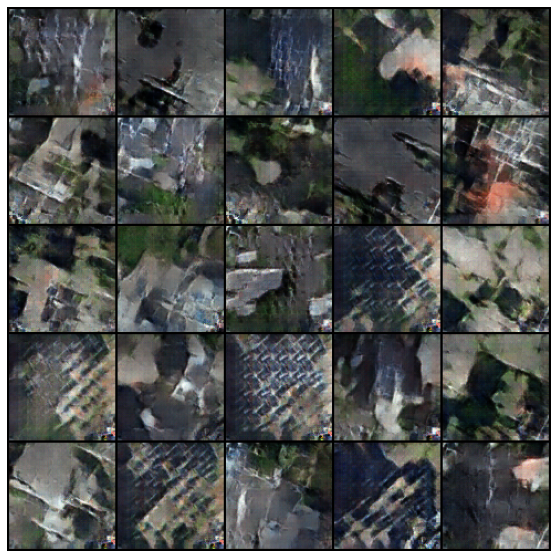

In [101]:
show_images(25)